# DL - CNN 

## 1. Imports

In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Rescaling

# model building imports
from keras import Model, Sequential, Input

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
# model training imports
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler


from keras.layers import RandomContrast, RandomSharpness
from keras.regularizers import l2
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandAugment

#### Splitting the dataset into Train/ Val/ Test

In [30]:
### Ja feito no outro notebook.

#### Data Loading

In [2]:
train = keras.utils.image_dataset_from_directory(
    directory = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/train",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=True,
    interpolation = "bilinear"
)

validation = keras.utils.image_dataset_from_directory(
    directory = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/val",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

test = keras.utils.image_dataset_from_directory(
    directory = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto/rare_species 1/dataset_split/test",
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    color_mode="rgb",
    shuffle=False,
    interpolation = "bilinear"
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


#### Visualizing the Data

2025-04-03 15:31:43.888961: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


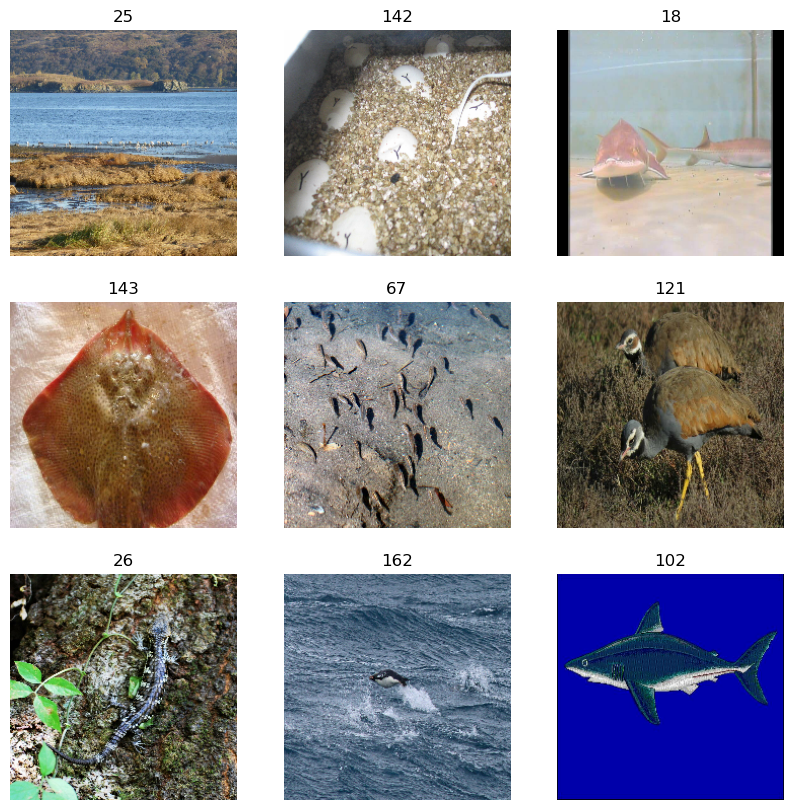

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")

#### Inspecting size to confirmm initial changes:

In [4]:
for images, labels in train.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Min Pixel Value: 255.0


2025-04-03 15:31:44.620778: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Same applies to test and validation sets!

In [5]:
for images, labels in validation.take(1):
    print("Image Batch Shape:", images.shape)
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))

Image Batch Shape: (32, 224, 224, 3)
Min Pixel Value: 0.0
Min Pixel Value: 255.0


The RGB Channel values are between 0-255 which is not ideal for a CNN, we must resize them between the [0;1] range.

#### Applying Resizing

In [6]:
normalization = Rescaling(1./255)

train = train.map(lambda x,y: (normalization(x), y))
validation = validation.map(lambda x,y: (normalization(x), y))
test = test.map(lambda x,y: (normalization(x), y))

In [7]:
### Checking RGB Pixel resize:
for images, labels in train.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


2025-04-03 15:31:47.148240: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
### Checking RGB Pixel resize:
for images, labels in validation.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


In [9]:
### Checking RGB Pixel resize:
for images, labels in test.take(1):
    print("Min Pixel Value:", np.min(images.numpy()))
    print("Min Pixel Value:", np.max(images.numpy()))


Min Pixel Value: 0.0
Min Pixel Value: 1.0


<hr>

#### Setting up TensorBoard for Monitorization - Callback

In [39]:
#pip install tensorboard

In [10]:
import datetime
tb_logs = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto"
log_directory = tb_logs + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

### Model Architecture

In [12]:
## Defining the main class which will be called and will contain our model's parameters.
## It inherits from keras.Model class

## Why

class CNN1(Model):

    def __init__(self, activation = "relu"):
        # Calling super().__init__ method refers to the parent class Model.
        # Why is this important? - register the model, it properly initializes the Keras Model class
        # allowing TF to manage layers, forward propagation, and model metadata correctly.

        # Allows Model Methods to Work --> Methods like .fit(), .predict(), and .save(), depend
        # on Model being initialized properly.
        super().__init__()


       #### BLOCK 1
        self.conv1_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_l")
        self.batch1 = BatchNormalization()
        self.conv1_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv1_r")
        self.batch2 = BatchNormalization()
        self.maxpool1 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool1")

        #### BLOCK 2
        self.conv2_l = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_l")
        self.batch3 = BatchNormalization()
        self.conv2_r = Conv2D(filters=3*64, kernel_size=(3,3), activation=activation, name="conv2_r")
        self.batch4 = BatchNormalization()
        self.maxpool2 = MaxPooling2D(pool_size=(2,2), padding="same", name="maxpool2")

        #### FLATTEN AND DENSE
        self.flatten_layer = Flatten()
        self.dropout_layer = Dropout(rate=0.5)
        self.batch5 = BatchNormalization()
        self.dense_layer = Dense(units=202, activation="softmax", name="classification")

    def call(self, inputs):
        x = inputs

        # BLOCK 1
        x_l = self.conv1_l(x)
        x_l = self.batch1(x_l)
        x_r = self.conv1_r(x)
        x_r = self.batch2(x_r)
        x = add(x_l,x_r)  
        x = self.maxpool1(x)

        # BLOCK 2
        x_l2 = self.conv2_l(x)
        x_l2 = self.batch3(x_l2)
        x_r2 = self.conv2_r(x)
        x_r2 = self.batch4(x_r2)
        x = add(x_l2,x_r2)
        x = self.maxpool2(x)

        x = self.flatten_layer(x)
        x = self.dropout_layer(x)
        x = self.batch5(x)
        x = self.dense_layer(x)

        return x

In [81]:
my_callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_directory),
    keras.callbacks.ModelCheckpoint(
        filepath = r"/Users/pedrosantos/Documents 2/Deep Learning/Projeto.weights.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    #keras.callbacks.EarlyStopping(
     #   monitor="val_accuracy",
      #  patience=4
    #),
    #keras.callbacks.ReduceLROnPlateau(
     #   monitor="val_accuracy",
      #  factor = 0.3,
       # mode="auto",
        #patience=3,
        #verbose=1,
        #min_lr = 0.0001
    #)
]

<hr>

#### Model Summary

In [13]:
model = CNN1()
inputs = Input(shape=(224,224,3))
_ = model.call(inputs)
model.summary()

NameError: name 'CNN1' is not defined

<hr>

<hr>

#### Infeasible to run this model, taking more than 10+ hours to run 4 epochs. 

#### It is clear than while trying both sides of the spectrum, neither a simple model, which trais fast will achieve decent results, nor a very complex one which might have the possibility to achieve the kind of accuracy we aim for, but it is just far too much time to spend, making us unable to run several experiments.

- For these reasos, we conclude that we should probably aim for a Transfer Learning approach, using model's pre-trained weights, and tweaking some architecture details as well as experimenting with Data Augmentation might be the best approach forward.

<hr>

# Transfer Learning

#### 1. XCEPTION

In [25]:
from tensorflow.keras.applications.xception import Xception  # ✅ Correct

from keras.layers import RandAugment

In [32]:
class Xception1(Model):
    def __init__(self):

        super().__init__()
        

        self.n_classes = 202
        self.augmentation_l = RandAugment(value_range=(0,1), factor=0.3)
        self.pretrained_model = Xception(include_top = False)
        self.flatten = Flatten()
        self.dense = Dense(self.n_classes, activation="softmax")

    def call(self,inputs):

        x = self.augmentation_l(inputs)
        x = self.pretrained_model(x)
        x = self.flatten(x)

        return self.dense(x)

In [33]:
model = Xception1()

In [34]:
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

In [35]:

model.compile(loss="categorical_crossentropy", optimizer=RMSprop(learning_rate=0.001), metrics=metrics)

model.summary()

Model: "xception1_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rand_augment_2 (RandAugment)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, None, None,     │    20,861,480 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [36]:
_ = model.fit(
    train,
    validation_data=validation,
    epochs=30,
    callbacks=my_callbacks,
    verbose=2
)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.03116, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 1421s - 5s/step - accuracy: 0.0320 - auc: 0.6335 - f1_score: 0.0028 - loss: 5.2609 - val_accuracy: 0.0312 - val_auc: 0.6431 - val_f1_score: 0.0033 - val_loss: 5.3391
Epoch 2/30

Epoch 2: val_accuracy improved from 0.03116 to 0.05231, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 1375s - 5s/step - accuracy: 0.1763 - auc: 0.8210 - f1_score: 0.0762 - loss: 3.9755 - val_accuracy: 0.0523 - val_auc: 0.6638 - val_f1_score: 0.0369 - val_loss: 5.4698
Epoch 3/30


KeyboardInterrupt: 

- Interrupted training on 4th epoch -> The train accuracy is 0.2344 but the al_accuracy remains very low -> 0.0684. Indicating that overfitting remains

Actions taken: Include Dropout layer and increase data augmentation factor!

<hr>

#### 2. EfficientnetV2S

In [59]:
from keras.applications import EfficientNetV2S

In [60]:
class EffNetV2S(Model):
    def __init__(self):

        super().__init__()
        

        self.n_classes = 202
        self.augmentation_l = RandAugment(value_range=(0,1), factor=0.3)
        self.pretrained_model = EfficientNetV2S(include_top = False)
        self.flatten = Flatten()
        self.droupout = Dropout(0.3)
        self.dense = Dense(self.n_classes, activation="softmax")

    def call(self,inputs):

        x = self.augmentation_l(inputs)
        x = self.pretrained_model(x)
        x = self.droupout(x)
        x = self.flatten(x)

        return self.dense(x)

In [61]:
model = EffNetV2S()
model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "eff_net_v2s"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rand_augment_1480 (RandAugment) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, None, None,     │    20,331,360 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,331,360 (77.56 MB)

 Trainable params: 20,177,488 (76.97 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [65]:
_ = model.fit(
    train,
    validation_data=validation,
    epochs=10,
    callbacks=my_callbacks,
    verbose=2
)

Epoch 1/10

Epoch 1: val_accuracy improved from 0.06845 to 0.10907, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 2970s - 11s/step - accuracy: 0.1229 - loss: 5.3844 - val_accuracy: 0.1091 - val_loss: 5.4179 - learning_rate: 1.0000e-03
Epoch 2/10

Epoch 2: val_accuracy improved from 0.10907 to 0.14302, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 3280s - 12s/step - accuracy: 0.2824 - loss: 3.7190 - val_accuracy: 0.1430 - val_loss: 5.3047 - learning_rate: 1.0000e-03
Epoch 3/10

Epoch 3: val_accuracy improved from 0.14302 to 0.15971, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 3144s - 12s/step - accuracy: 0.3957 - loss: 3.0065 - val_accuracy: 0.1597 - val_loss: 5.5826 - learning_rate: 1.0000e-03
Epoch 4/10

Epoch 4: val_accuracy improved from 0.15971 to 0.17195, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 3205s - 12s/step - accura

- Seems that overfitting is still persistent in most models we try as baseline. We have to try more agressive regularization such as a higher Dropout facotr, kernel regularizers, experiment more with data augmentation!

<hr>

## 3. ResNet50V2   

In [35]:
from keras.applications import ResNet50V2

#### Key modifications:

- dropout(0.6)
- l2(0.2)
- Increased Data Augmentation

In [69]:
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class ResNet(Model):
    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        

        self.n_classes = 202
        self.augmentation_l = Sequential([
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(0.5),
            RandomZoom(0.2),
            RandomContrast(0.1, value_range=(0,1)),
            RandomSharpness(0.1, value_range=(0,1))
        ])
        self.pretrained_model = ResNet50V2(include_top = False)
        self.pretrained_model.trainable = False

        self.flatten = Flatten()
        self.dropout = Dropout(0.5)
        self.dense = Dense(self.n_classes, activation="softmax", kernel_regularizer=l2(0.01))

    def call(self,inputs, training=False):

        x = self.augmentation_l(inputs, training=training)
        x = self.pretrained_model(x)
        x = self.flatten(x)
        x = self.dropout(x, training=training)

        return self.dense(x)

In [70]:
model = ResNet()
inputs = Input((224,224,3))
_ = model.call(inputs)
model.summary()

Model: "res_net_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 202)            │    20,271,306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,836,106 (167.22 MB)

 Trainable params: 20,271,306 (77.33 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [50]:
for layer in model.pretrained_model.layers[-10:]:
    layer.trainable = True
    print(layer.name, layer.trainable)

conv5_block3_1_bn True
conv5_block3_1_relu True
conv5_block3_2_pad True
conv5_block3_2_conv True
conv5_block3_2_bn True
conv5_block3_2_relu True
conv5_block3_3_conv True
conv5_block3_out True
post_bn True
post_relu True


In [51]:
model.compile(optimizer=RMSprop(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
_ = model.fit(
    sample_train,
    validation_data=sample_val,
    epochs=25,
    steps_per_epoch = 1500 // 8,
    validation_steps = 500 // 8,
    callbacks=my_callbacks,
    verbose=2)

Epoch 1/25

Epoch 1: val_accuracy did not improve from 0.29839
187/187 - 87s - 467ms/step - accuracy: 0.0134 - loss: 11.9810 - val_accuracy: 0.0403 - val_loss: 10.4104
Epoch 2/25

Epoch 2: val_accuracy did not improve from 0.29839
187/187 - 80s - 429ms/step - accuracy: 0.0261 - loss: 10.5180 - val_accuracy: 0.0847 - val_loss: 9.4444
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.29839
187/187 - 83s - 442ms/step - accuracy: 0.0528 - loss: 9.4394 - val_accuracy: 0.1331 - val_loss: 8.5537
Epoch 4/25

Epoch 4: val_accuracy did not improve from 0.29839
187/187 - 84s - 449ms/step - accuracy: 0.0608 - loss: 8.6419 - val_accuracy: 0.1794 - val_loss: 7.8504
Epoch 5/25

Epoch 5: val_accuracy did not improve from 0.29839
187/187 - 84s - 447ms/step - accuracy: 0.0989 - loss: 7.8239 - val_accuracy: 0.2157 - val_loss: 7.3354
Epoch 6/25

Epoch 6: val_accuracy did not improve from 0.29839
187/187 - 80s - 429ms/step - accuracy: 0.1170 - loss: 7.3106 - val_accuracy: 0.2278 - val_loss: 6.9319
E

In [71]:
from tensorflow.keras.models import load_model

model = load_model(
    "/Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras",
    custom_objects={"ResNet": ResNet}
)



/opt/anaconda3/envs/DL/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 13 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [74]:
# Unfreeze top 20 layers of the ResNet base
for layer in model.layers[1].layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=RMSprop(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [75]:
fine_tune = model.fit(
    train,
    validation_data=validation,
    epochs=20,
    callbacks=my_callbacks,
    verbose=2
)

Epoch 1/20

Epoch 1: val_accuracy did not improve from 0.36694
263/263 - 364s - 1s/step - accuracy: 0.2194 - loss: 7.3773 - val_accuracy: 0.2755 - val_loss: 7.1383
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.36694
263/263 - 371s - 1s/step - accuracy: 0.2475 - loss: 7.4007 - val_accuracy: 0.3038 - val_loss: 7.2944
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.36694
263/263 - 367s - 1s/step - accuracy: 0.2792 - loss: 7.5507 - val_accuracy: 0.3278 - val_loss: 7.5324
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.36694
263/263 - 367s - 1s/step - accuracy: 0.3070 - loss: 7.7526 - val_accuracy: 0.3500 - val_loss: 7.7976
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.36694
263/263 - 366s - 1s/step - accuracy: 0.3243 - loss: 7.9873 - val_accuracy: 0.3628 - val_loss: 8.0815
Epoch 6/20

Epoch 6: val_accuracy improved from 0.36694 to 0.37841, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 362s - 1s/step - accuracy: 

#### Squuezing out more performance from this batch of training

- Unfreezing more layers from pretrianed model
- Modify Droupout
- Modify Augmentation


In [76]:
model = load_model(
    "/Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras",
    custom_objects={"ResNet": ResNet}
)

/opt/anaconda3/envs/DL/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 21 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [77]:

class ResNetModified(Model):
    def __init__(self):
        super().__init__()
        self.n_classes = 202
        self.augmentation_l = Sequential([
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(0.4),
            RandomZoom(0.3),
            RandomContrast(0.15, value_range=(0,1)),
            RandomSharpness(0.2, value_range=(0,1))
        ])
        self.pretrained_model = ResNet50V2(include_top=False)
        self.pretrained_model.trainable = False 

        self.flatten = Flatten()
        self.dropout = Dropout(0.6) 
        self.dense = Dense(self.n_classes, activation="softmax", kernel_regularizer=l2(0.01))

    def call(self, inputs, training=False):
        x = self.augmentation_l(inputs, training=training)
        x = self.pretrained_model(x)
        x = self.flatten(x)
        x = self.dropout(x, training=training)
        return self.dense(x)

# Instantiate and build the modified model
model_mod = ResNetModified()
_ = model_mod(tf.keras.Input(shape=(224, 224, 3))) 
model_mod.set_weights(model.get_weights())         


In [82]:
for layer in model_mod.pretrained_model.layers[-50:]:
    layer.trainable = True

In [83]:
for layer in model_mod.pretrained_model.layers[-50:]:
    print(layer.name, layer.trainable)

conv4_block5_3_conv True
conv4_block5_out True
conv4_block6_preact_bn True
conv4_block6_preact_relu True
conv4_block6_1_conv True
conv4_block6_1_bn True
conv4_block6_1_relu True
conv4_block6_2_pad True
conv4_block6_2_conv True
conv4_block6_2_bn True
conv4_block6_2_relu True
max_pooling2d_41 True
conv4_block6_3_conv True
conv4_block6_out True
conv5_block1_preact_bn True
conv5_block1_preact_relu True
conv5_block1_1_conv True
conv5_block1_1_bn True
conv5_block1_1_relu True
conv5_block1_2_pad True
conv5_block1_2_conv True
conv5_block1_2_bn True
conv5_block1_2_relu True
conv5_block1_0_conv True
conv5_block1_3_conv True
conv5_block1_out True
conv5_block2_preact_bn True
conv5_block2_preact_relu True
conv5_block2_1_conv True
conv5_block2_1_bn True
conv5_block2_1_relu True
conv5_block2_2_pad True
conv5_block2_2_conv True
conv5_block2_2_bn True
conv5_block2_2_relu True
conv5_block2_3_conv True
conv5_block2_out True
conv5_block3_preact_bn True
conv5_block3_preact_relu True
conv5_block3_1_conv Tru

In [84]:
model_mod.compile(
    optimizer=RMSprop(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [85]:
fine_tuned_model = model_mod.fit(
    train,
    validation_data=validation,
    epochs=20,
    callbacks=my_callbacks,
    verbose=2
)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.46021, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.weights.h5
263/263 - 463s - 2s/step - accuracy: 0.4574 - loss: 12.6966 - val_accuracy: 0.4602 - val_loss: 12.9682
Epoch 2/20

Epoch 2: val_accuracy improved from 0.46021 to 0.46800, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.weights.h5
263/263 - 482s - 2s/step - accuracy: 0.4757 - loss: 12.9677 - val_accuracy: 0.4680 - val_loss: 13.2986
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.46800
263/263 - 469s - 2s/step - accuracy: 0.4901 - loss: 13.2086 - val_accuracy: 0.4680 - val_loss: 13.5635
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.46800
263/263 - 456s - 2s/step - accuracy: 0.4974 - loss: 13.4798 - val_accuracy: 0.4674 - val_loss: 13.8521
Epoch 5/20

Epoch 5: val_accuracy improved from 0.46800 to 0.47579, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.weights.h5
263/263 - 444s - 2s/s

KeyboardInterrupt: 

<hr>

## 4. VGG16   

In [11]:
from keras.applications import VGG16

In [12]:
class VGG(Model):
    def __init__(self):

        super().__init__()
        

        self.n_classes = 202
        #self.augmentation_l = Sequential([
           #RandomFlip("horizontal_and_vertical"),
            #RandomRotation(0.5),
            #RandomZoom(0.2),
            #RandomContrast(0.1, value_range=(0,1)),
            #RandomSharpness(0.1, value_range=(0,1))
        #[)
        
        self.aug = RandAugment(
            value_range=(0,1)
        )

        self.pretrained_model = VGG16(include_top = False)
        self.pretrained_model.trainable = False

        self.flatten = Flatten()
        self.dropout = Dropout(0.5)
        self.dense = Dense(self.n_classes, activation="softmax", kernel_regularizer=l2(0.02))

    def call(self,inputs,training=False):

        x = self.aug(inputs, training=training)
        #x = self.augmentation_l(inputs)
        x = self.pretrained_model(x, training=False)
        x = self.flatten(x)
        x = self.dropout(x, training=training)

        return self.dense(x)

In [13]:
model = VGG()
inputs = Input((224,224,3))
_ = model.call(inputs)
model.summary()

Model: "vgg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rand_augment (RandAugment)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │     5,067,978 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,782,666 (75.46 MB)

 Trainable params: 5,067,978 (19.33 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
model.compile(optimizer=RMSprop(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
for layer in model.layers:
    print(layer.name,layer.trainable)

rand_augment True
vgg16 False
flatten True
dropout True
dense True


In [ ]:
_ = model.fit(
    train,
    validation_data=validation,
    epochs=7,
    callbacks=my_callbacks,
    verbose=2,
    batch_size=64)

Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.01391, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 962s - 4s/step - accuracy: 0.0302 - loss: 102.9940 - val_accuracy: 0.0139 - val_loss: 124.9995 - learning_rate: 0.0100
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.01391
263/263 - 994s - 4s/step - accuracy: 0.0372 - loss: 114.6578 - val_accuracy: 0.0089 - val_loss: 126.8555 - learning_rate: 0.0100
Epoch 3/20

Epoch 3: val_accuracy improved from 0.01391 to 0.02226, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 990s - 4s/step - accuracy: 0.0356 - loss: 127.7875 - val_accuracy: 0.0223 - val_loss: 139.0738 - learning_rate: 0.0100
Epoch 4/20

Epoch 4: val_accuracy improved from 0.02226 to 0.02449, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
263/263 - 1002s - 4s/step - accuracy: 0.0349 - loss: 133.2896 - val_accuracy: 0.0245 - val_loss: 124.9648 - learning_rate: 0

Problems: Model seems to have trouble learning; Could be due to severe data augmentation, Our training loss is increasing, which is unusual. Validaion loss is also fluctuating. Lets try and run the model without data augmentation to see a base result. And also we should perhaps unfreeze some of the VGG16 layers.

- worst case could be a a data/labelling Problem. We should train a batch of original images and check predictions manually to see if it makes sense.

- We also should take a sample from now on to speed the process and test several hypothesis. Additionally, if a model can easily overfit to the tiny dataset, its most likely working. If it cant memorize a tiny dataset, something could be off (augmentation, lr, architectute), etc

In [12]:
### TEST WITH SAMPLED DATA AND MINOR AUGMENTATION
sample_train = (
    train.unbatch().take(1500).repeat().batch(8)
)

sample_val = (
    validation.unbatch().take(500).repeat().batch(8)
)


In [15]:
class VGG_sampled_no_aug(Model):
    def __init__(self):

        super().__init__()
        

        self.n_classes = 202
        self.augmentation_l = Sequential([
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(0.5),
            RandomZoom(0.2),
            RandomContrast(0.1, value_range=(0,1)),
            RandomSharpness(0.1, value_range=(0,1))
        ])
        
        #self.aug = RandAugment(
         #   value_range=(0,1)
        #)

        self.pretrained_model = VGG16(include_top = False)
        self.pretrained_model.trainable = False

        self.flatten = Flatten()
        self.dropout = Dropout(0.1)
        self.dense = Dense(self.n_classes, activation="softmax")

    def call(self,inputs,training=False):

        #x = self.aug(inputs, training=training)
        x = self.augmentation_l(inputs)
        x = self.pretrained_model(x, training=False)
        x = self.flatten(x)
        x = self.dropout(x, training=training)

        return self.dense(x)

In [16]:
model2 = VGG_sampled_no_aug()
inputs = Input((224,224,3))
outputs = model2(inputs)
model2.summary()

Model: "vgg_sampled_no_aug"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, None, None,     │    14,714,688 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 202)            │     5,067,978 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,782,666 (75.46 MB)

 Trainable params: 5,067,978 (19.33 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
for layer in model2.pretrained_model.layers[-3:]:
    layer.trainable = True

In [18]:
for layer in model2.layers:
    print(layer.name, layer.trainable)

sequential True
vgg16 False
flatten_1 True
dropout_1 True
dense_1 True


In [19]:
model2.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
_ = model2.fit(
    sample_train,
    validation_data=sample_val,
    epochs=25,
    steps_per_epoch = 1500 // 8,
    validation_steps = 500 // 8,
    callbacks=my_callbacks,
    verbose=2)

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
187/187 - 215s - 1s/step - accuracy: 0.0207 - loss: 5.4037 - val_accuracy: 0.0000e+00 - val_loss: 5.1231 - learning_rate: 0.0010
Epoch 2/25

Epoch 2: val_accuracy improved from 0.00000 to 0.06048, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
187/187 - 219s - 1s/step - accuracy: 0.0301 - loss: 5.0840 - val_accuracy: 0.0605 - val_loss: 5.0146 - learning_rate: 0.0010
Epoch 3/25

Epoch 3: val_accuracy did not improve from 0.06048
187/187 - 208s - 1s/step - accuracy: 0.0348 - loss: 5.0181 - val_accuracy: 0.0544 - val_loss: 4.8790 - learning_rate: 0.0010
Epoch 4/25

Epoch 4: val_accuracy improved from 0.06048 to 0.07056, saving model to /Users/pedrosantos/Documents 2/Deep Learning/Projeto.keras
187/187 - 214s - 1s/step - accuracy: 0.0401 - loss: 4.9771 - val_accuracy: 0.0706 - val_loss: 4.8278 - learning_rate: 0.0010
Epoch 5

#### Small test on tiny dataset:

In [21]:
allowed_classes = tf.constant([0, 1], dtype=tf.int32)

filtered_train = (
    train.unbatch()
         .filter(lambda x, y: tf.reduce_any(tf.equal(tf.argmax(y, output_type=tf.int32), allowed_classes)))
         .take(40)
         .repeat()
         .batch(8)
)

filtered_val = (
    validation.unbatch()
              .filter(lambda x, y: tf.reduce_any(tf.equal(tf.argmax(y, output_type=tf.int32), allowed_classes)))
              .take(20)
              .repeat()
              .batch(8)
)



model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model2.fit(
    filtered_train,
    validation_data=filtered_val,
    epochs=15,
    steps_per_epoch=5,
    validation_steps=2
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4583 - loss: 3.5948 - val_accuracy: 1.0000 - val_loss: 0.0189
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9288 - loss: 0.4739 - val_accuracy: 1.0000 - val_loss: 4.0827e-04
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9781 - loss: 0.0278 - val_accuracy: 0.9375 - val_loss: 0.1301
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9073 - loss: 0.3552 - val_accuracy: 1.0000 - val_loss: 0.0222
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9375 - val_loss: 0.1841
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9917 - loss: 0.1835 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8958 - loss: 1.7300 - val_accuracy: 0.9375 - val_loss: 0.2242
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.9608 - loss: 0.0754 - val_accuracy: 1.0000 - val_loss: 0.0363


- Great to see: When testing with very small dataset model overfits clearly, Which is a good sign that pipeline overall works and the data is ok.

Now if its struggling in the full dataset its most likely due to:
- either too much augmentation (but we alredy tried without and stilll struggles)
- Insufficient training time (possible)
- Class imbalance
- Not enough leranable parameters (e.g. frozen base)

#### Visualizing my Data Augmentation Pipeline

In [12]:
augmentation_pipeline = Sequential([
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(0.7),
            RandomZoom(0.1),
            RandomContrast(0.5, value_range=(0,1)),
            RandomSharpness(0.5, value_range=(0,1))])

In [15]:
from keras.layers import RandAugment

In [20]:
aug = Sequential([
    RandAugment(
        value_range=(0,1)
    )
])

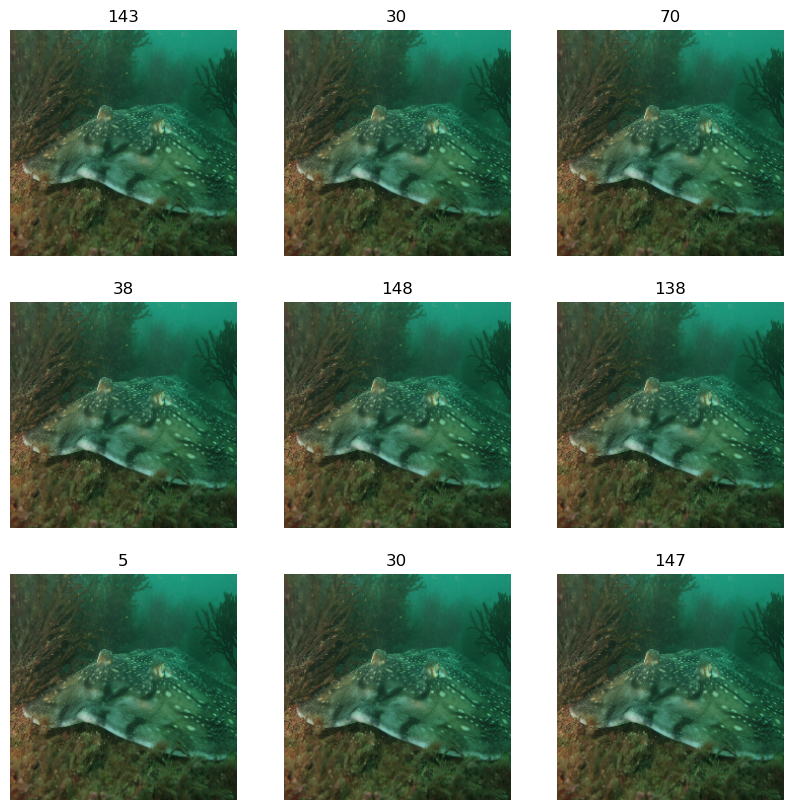

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        # Apply augmentation (pipeline expects a batch, so add batch dimension)
        augmented_image = aug(tf.expand_dims(images[i], 0))

        ax = plt.subplot(3, 3, i + 1)

        # Remove batch dimension, multiply by 255, cast to uint8
        img = (augmented_image[0].numpy() * 255).astype("uint8")

        plt.imshow(img)
        plt.title(int(np.argmax(labels[i])))
        plt.axis("off")


#### TensorBoard Monitorization

In [ ]:
%load_ext tensorboard
%tensorboard --logdir= tb_logs